In [29]:
# Librerías necesarias
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
from scipy.interpolate import griddata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# === Cargar shapefiles ===
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)

# === Generar pseudo-ausencias ===
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
bbox_col = box(-80, -5, -65, 15)
rng = np.random.default_rng(42)
pseudo = []
while len(pseudo) < num_depos:
    x, y = rng.uniform(-80, -65), rng.uniform(-5, 15)
    p = Point(x, y)
    if bbox_col.contains(p):
        pseudo.append(p)
gdf_aus = gpd.GeoDataFrame(geometry=pseudo, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# === Unir y crear coordenadas ===
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# === Interpolación del Moho ===
pts = [(geom.x, geom.y) for geom in gdf_moho.geometry]
zs = gdf_moho["Z"].values
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_z = griddata(pts, zs, (grid_x, grid_y), method="cubic")
grid_z[np.isnan(grid_z)] = griddata(pts, zs, (grid_x[np.isnan(grid_z)], grid_y[np.isnan(grid_z)]), method="nearest")

# === Interpolación de EdadMa (filtrada < 4000 Ma) ===
gdf_dataciones["EdadMa"] = pd.to_numeric(gdf_dataciones["EdadMa"].str.replace(",", "."), errors="coerce")
gdf_dataciones = gdf_dataciones[gdf_dataciones["EdadMa"] <= 4000]
valid_edad = gdf_dataciones.dropna(subset=["EdadMa"])
coords_edad = np.array([[p.x, p.y] for p in valid_edad.geometry])
z_edad = valid_edad["EdadMa"].values
grid_edad = griddata(coords_edad, z_edad, (grid_x, grid_y), method="cubic")
grid_edad[np.isnan(grid_edad)] = griddata(coords_edad, z_edad, (grid_x[np.isnan(grid_edad)], grid_y[np.isnan(grid_edad)]), method="nearest")
grid_edad_clean = np.where(grid_edad < 0, np.nan, grid_edad)

# === Función para muestreo de grillas ===
def sample_grid_value(x, y, grid):
    ix = int((x - (-80)) / ((-65 + 80) / 500))
    iy = int((15 - y) / ((15 + 5) / 500))
    return grid[iy, ix] if 0 <= ix < 500 and 0 <= iy < 500 else np.nan

# === Aplicar muestreo de Moho y Edad ===
gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_z), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad_clean), axis=1)

# === Eliminar puntos con EdadMa > 4000 (por seguridad tras interpolación) ===
gdf_total = gdf_total[gdf_total["EdadMa"] <= 4000]

# === Modelo logístico ===
gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa"])
X = gdf_modelo[["Moho_Z", "EdadMa"]].values
y = gdf_modelo["Presencia"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# === Reporte ===
report = classification_report(y_test, y_pred, digits=3)
cmatrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
coef = model.coef_[0]
intercept = model.intercept_[0]

print(f"""
=== MODELO DE REGRESIÓN LOGÍSTICA ===

Variables predictoras:
 - Moho_Z (profundidad del Moho)
 - EdadMa (edad interpolada en millones de años, filtrada < 4000)

--- MÉTRICAS DE EVALUACIÓN ---

Classification Report:
{report}

Confusion Matrix:
{cmatrix}

Accuracy: {acc:.3f}
AUC-ROC: {auc:.3f}

--- COEFICIENTES DEL MODELO ---

Intercept (log-odds base): {intercept:.6f}
Coeficiente Moho_Z:         {coef[0]:.6f}
Coeficiente EdadMa:         {coef[1]:.6f}

Interpretación:
- Cada km adicional en la profundidad del Moho influye {('positivamente' if coef[0]>0 else 'negativamente')} sobre la probabilidad de presencia de un depósito.
- La edad (EdadMa) tiene un efecto {('positivo' if coef[1]>0 else 'negativo')}, indicando que los depósitos tienden a asociarse con zonas más {('antiguas' if coef[1]>0 else 'jóvenes')}.
- El modelo muestra un desempeño global aceptable con una AUC de {auc:.3f}.

Limitaciones:
- Las pseudo-ausencias se generaron aleatoriamente y podrían introducir sesgo.
- Solo se usaron dos variables predictoras (Moho y Edad).
- Se asume una relación lineal entre las variables y la log-odds, lo cual puede no capturar toda la complejidad del sistema geológico.
""")



=== MODELO DE REGRESIÓN LOGÍSTICA ===

Variables predictoras:
 - Moho_Z (profundidad del Moho)
 - EdadMa (edad interpolada en millones de años, filtrada < 4000)

--- MÉTRICAS DE EVALUACIÓN ---

Classification Report:
              precision    recall  f1-score   support

           0      0.742     0.690     0.715       229
           1      0.742     0.788     0.764       259

    accuracy                          0.742       488
   macro avg      0.742     0.739     0.739       488
weighted avg      0.742     0.742     0.741       488


Confusion Matrix:
[[158  71]
 [ 55 204]]

Accuracy: 0.742
AUC-ROC: 0.878

--- COEFICIENTES DEL MODELO ---

Intercept (log-odds base): -5.384279
Coeficiente Moho_Z:         0.089355
Coeficiente EdadMa:         0.001548

Interpretación:
- Cada km adicional en la profundidad del Moho influye positivamente sobre la probabilidad de presencia de un depósito.
- La edad (EdadMa) tiene un efecto positivo, indicando que los depósitos tienden a asociarse con zo

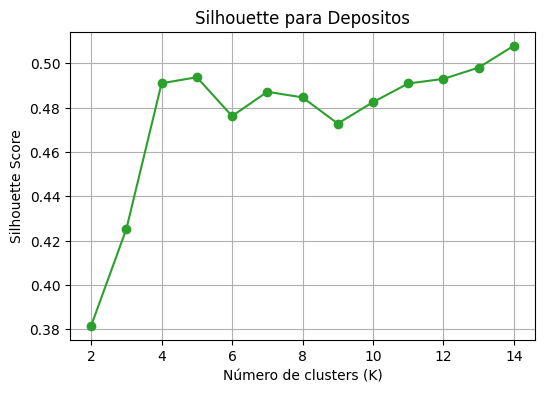

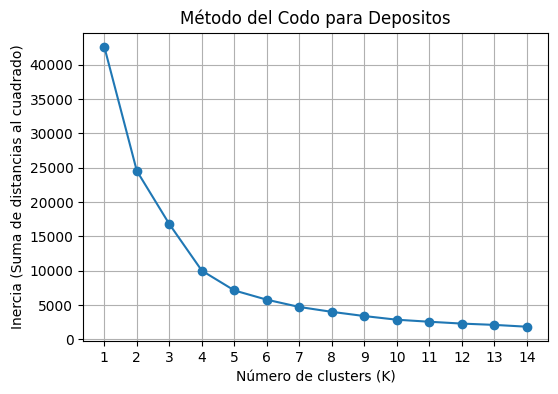

In [3]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Carga tus depósitos y extrae coordenadas
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
coords = np.vstack([gdf_depositos.geometry.x, gdf_depositos.geometry.y]).T

# 2. Probar varios valores de K y guardar la inercia
inertias = []
K_range = range(1, 15)  # prueba K = 1..14
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(coords)
    inertias.append(km.inertia_)
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(coords)
    sil_scores.append(silhouette_score(coords, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(range(2,15), sil_scores, '-o', color='tab:green')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette para Depositos")
plt.grid(True)
plt.show()
# 3. Dibujar la curva del codo
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, '-o', color='tab:blue')
plt.xticks(K_range)
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias al cuadrado)")
plt.title("Método del Codo para Depositos")
plt.grid(True)
plt.show()


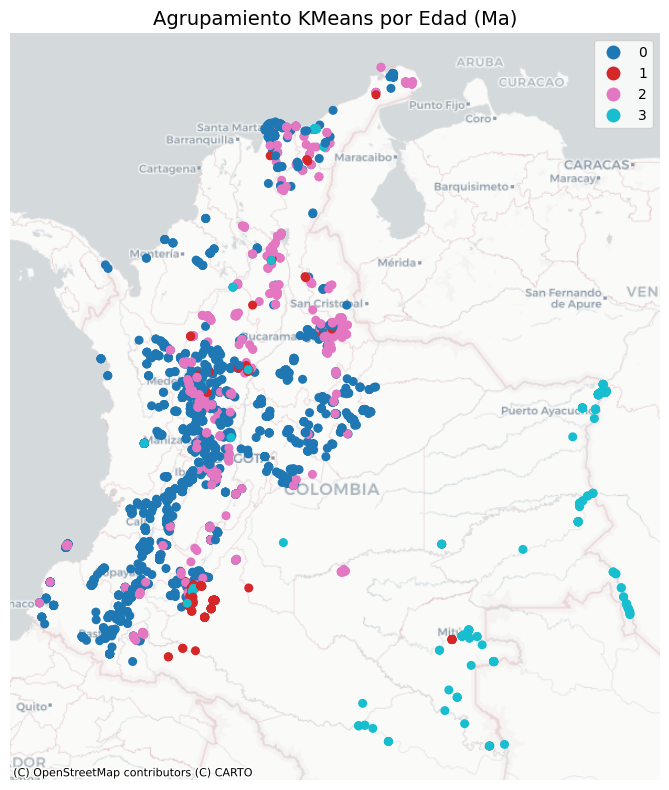

In [20]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import contextily as ctx
import pandas as pd

# 1. Cargar datos y reproyectar
gdf = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=3857)

# 2. Convertir EdadMa a numérico
gdf["EdadMa"] = gdf["EdadMa"].str.replace(",", ".")
gdf["EdadMa"] = pd.to_numeric(gdf["EdadMa"], errors="coerce")

# 3. Filtrar filas con edad válida
gdf = gdf.dropna(subset=["EdadMa"])

# 4. KMeans sobre EdadMa
X = gdf[["EdadMa"]].values
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
gdf["cluster_edad"] = kmeans.fit_predict(X)

# 5. Plot general con todos los puntos
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    ax=ax,
    column="cluster_edad",
    categorical=True,
    legend=True,
    markersize=30,
    cmap="tab10"
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("Agrupamiento KMeans por Edad (Ma)", fontsize=14)
plt.tight_layout()
plt.show()


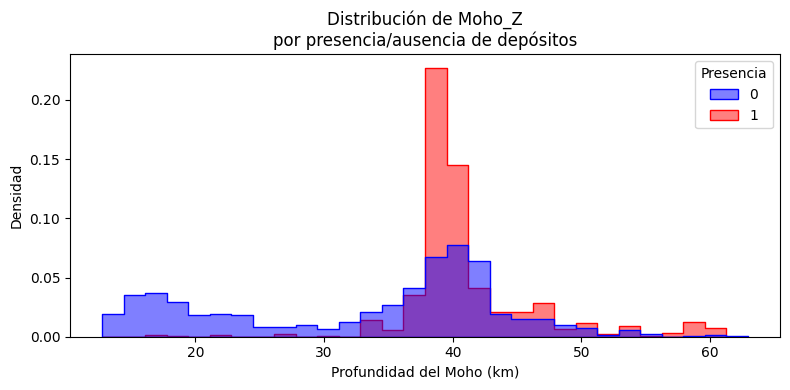

C:\TEMP\ipykernel_21200\997622442.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=gdf_plot.assign(Presencia=gdf_plot["Presencia"].astype(str)),


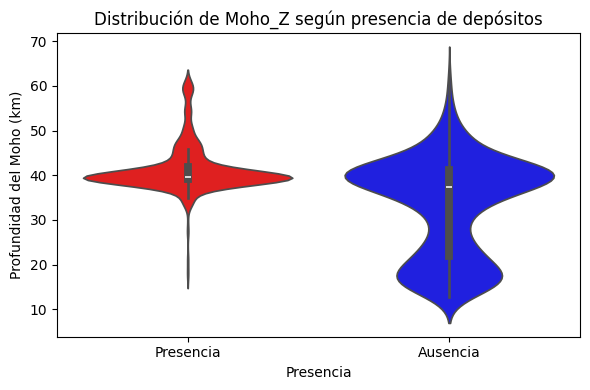

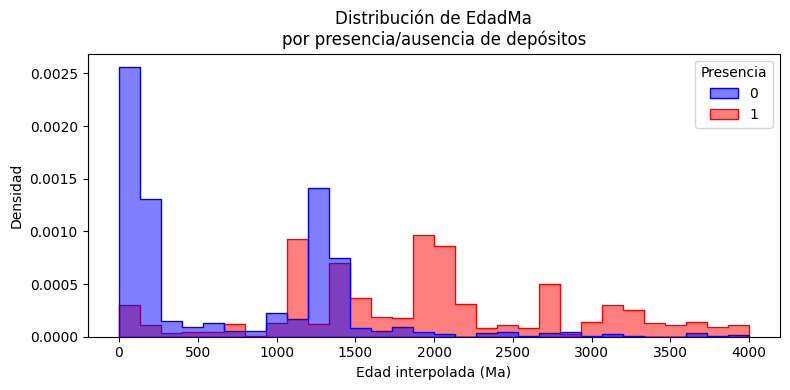

C:\TEMP\ipykernel_21200\997622442.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=gdf_plot.assign(Presencia=gdf_plot["Presencia"].astype(str)),


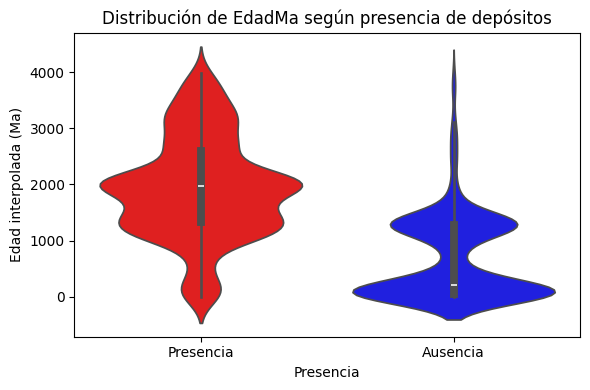

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Filtrar edades mayores a 4000 Ma ===
gdf_plot = gdf_total[gdf_total["EdadMa"] <= 4000]

# === Histograma comparado: Moho_Z ===
plt.figure(figsize=(8, 4))
sns.histplot(data=gdf_plot, x="Moho_Z", hue="Presencia",
             element="step", stat="density", common_norm=False,
             palette={0: "blue", 1: "red"}, alpha=0.5, bins=30)
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("Densidad")
plt.title("Distribución de Moho_Z\npor presencia/ausencia de depósitos")
plt.tight_layout()
plt.show()

# === Violin plot: Moho_Z ===
plt.figure(figsize=(6, 4))
sns.violinplot(data=gdf_plot.assign(Presencia=gdf_plot["Presencia"].astype(str)),
               x="Presencia", y="Moho_Z", palette={"0": "blue", "1": "red"})
plt.xticks([1, 0], ["Ausencia", "Presencia"])
plt.ylabel("Profundidad del Moho (km)")
plt.title("Distribución de Moho_Z según presencia de depósitos")
plt.tight_layout()
plt.show()

# === Histograma comparado: EdadMa ===
plt.figure(figsize=(8, 4))
sns.histplot(data=gdf_plot, x="EdadMa", hue="Presencia",
             element="step", stat="density", common_norm=False,
             palette={0: "blue", 1: "red"}, alpha=0.5, bins=30)
plt.xlabel("Edad interpolada (Ma)")
plt.ylabel("Densidad")
plt.title("Distribución de EdadMa\npor presencia/ausencia de depósitos")
plt.tight_layout()
plt.show()

# === Violin plot: EdadMa ===
plt.figure(figsize=(6, 4))
sns.violinplot(data=gdf_plot.assign(Presencia=gdf_plot["Presencia"].astype(str)),
               x="Presencia", y="EdadMa", palette={"0": "blue", "1": "red"})
plt.xticks([1, 0], ["Ausencia", "Presencia"])
plt.ylabel("Edad interpolada (Ma)")
plt.title("Distribución de EdadMa según presencia de depósitos")
plt.tight_layout()
plt.show()


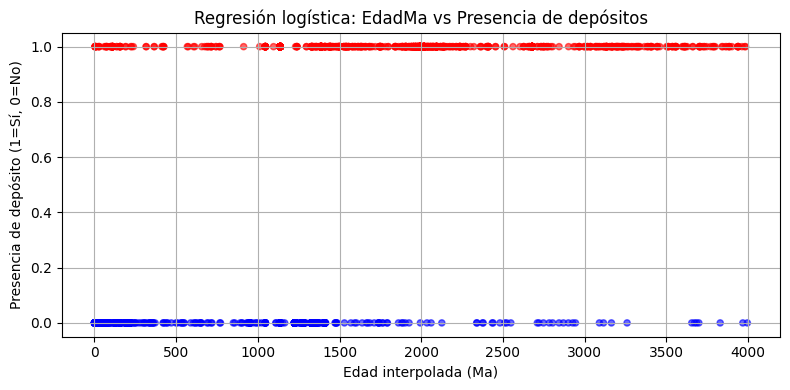

In [32]:
import matplotlib.pyplot as plt

# === Filtrar datos: solo EdadMa <= 4000 ===
gdf_plot = gdf_total[gdf_total["EdadMa"] <= 4000]

# === Scatter plot ===
plt.figure(figsize=(8, 4))
plt.scatter(gdf_plot["EdadMa"], gdf_plot["Presencia"],
            c=gdf_plot["Presencia"], cmap="bwr", s=20, alpha=0.6)
plt.xlabel("Edad interpolada (Ma)")
plt.ylabel("Presencia de depósito (1=Sí, 0=No)")
plt.title("Regresión logística: EdadMa vs Presencia de depósitos")
plt.grid(True)
plt.tight_layout()
plt.show()
